In [408]:
import torch
import warnings
import numpy as np
import pandas as pd
import scienceplots
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple

warnings.filterwarnings("ignore")
plt.style.use(['science', 'no-latex', 'ieee'])
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'figure.dpi': '100'})

### Reinforce with baseline

В работе рассматриваются работы алгоритмов REINFORCE with Baseline. Реализации алгоритмов

**Реализации алгоритмов**

Можно найти в папке `scripts`


#### Сетапы экспериментов

Политики для всех трех алгоритмов обучались $1500$ эпизодов. Начальный шаг оптимизации $lr=1e-2$, уменьшение шага осуществлялось при помощи $CosineAnnealingLR$ ($\eta_{min}=1e-5$, $T_{max} = 2000$), фактор дисконтирования $\gamma=0.99$, коэффициенты энтропийной регуляризации $\beta \in [0.0, 0.001, 0.01, 0.1, 1]$. Для обучения были выделены $\text{seeds}_{train} \in [0, 199]$, зацикленные до количества эпизодов, для валидации $\text{seeds}_{eval} \in [10.000, 10.099]$

Сама политика - это двухслойная нейронная сеть с размером скрытого состояния $h=128$, и дропаутом между слоями с $p_{dropout}=0.6$, имеющая $4$ входа (observation space dimension) и $2$ выхода (action space dimension).

В качестве среды для обучения был выбран `Cart-Pole-v1` из пакета `gymnasium`. Для успешно обучения порог успешного прохождения экспериментов был сдвинут до $1000$ шагов. Для валидации до $700$ шагов.

Для политики, обучаемой вместе с `ValueNetwork` были выставлены $lr=1e-2$, уменьшение шага осуществлялось при помощи $CosineAnnealingLR$ ($\eta_{min}=1e-5$, $T_{max} = 2000$)

### Графики обучения

In [411]:
train_reward = pd.read_csv('../data/value_function/train_reward.csv')
train_entropy = pd.read_csv('../data/value_function/train_entropy.csv')
eval_entropy = pd.read_csv('../data/value_function/eval_entropy.csv')
eval_reward = pd.read_csv('../data/value_function/eval_reward.csv')
eval_min_reward = pd.read_csv('../data/value_function/eval_min_reward.csv')

value_function_dfs = [
    train_reward,
    train_entropy,
    eval_entropy,
    eval_reward,
    eval_min_reward,
]

value_function_prefixes = [
    ('cart-pole-value_function-reward-baseline-2025-03-11-18-35-47', 0.1),
    ('cart-pole-value_function-reward-baseline-2025-03-10-15-38-32', 1.0),
    ('cart-pole-value_function-reward-baseline-2025-03-10-14-03-52', 0.01),
    ('cart-pole-value_function-reward-baseline-2025-03-10-11-55-39', 0.001),
    ('cart-pole-value_function-reward-baseline-2025-03-10-09-02-33', 0),
]

In [412]:
def map_dataframe_columns(prefix_to_entropy_mappings: Dict[str, float], df: pd.DataFrame) -> pd.DataFrame:
    # delete min/max stat
    _df = df.loc[:,~df.columns.str.contains('MIN|MAX')].copy()
    _df.rename(columns={'MIN': 'min', 'MAX': 'max'}, inplace=True)
    # get suffix
    suf = list(_df.columns)[1].split(' ')[-1]
    formatted_columns_dict = dict(map(lambda x: (x[0] +' - '+ suf, 'beta_' + str(x[1]).replace('.', '_')) , prefix_to_entropy_mappings))
    _df.rename(columns=formatted_columns_dict, inplace=True)
    return _df

def map_dataframes(prefix_to_entropy_mappings: dict[str, float], dfs: list[pd.DataFrame]) -> tuple[pd.DataFrame]:
    mapped_dfs = []
    for df_idx, df in enumerate(dfs):
        mapped_dfs.append(map_dataframe_columns(prefix_to_entropy_mappings, df))
    return tuple(mapped_dfs)

In [413]:
    (train_reward,
    train_entropy,
    eval_entropy,
    eval_reward,
    eval_min_reward) =  map_dataframes(value_function_prefixes, value_function_dfs)

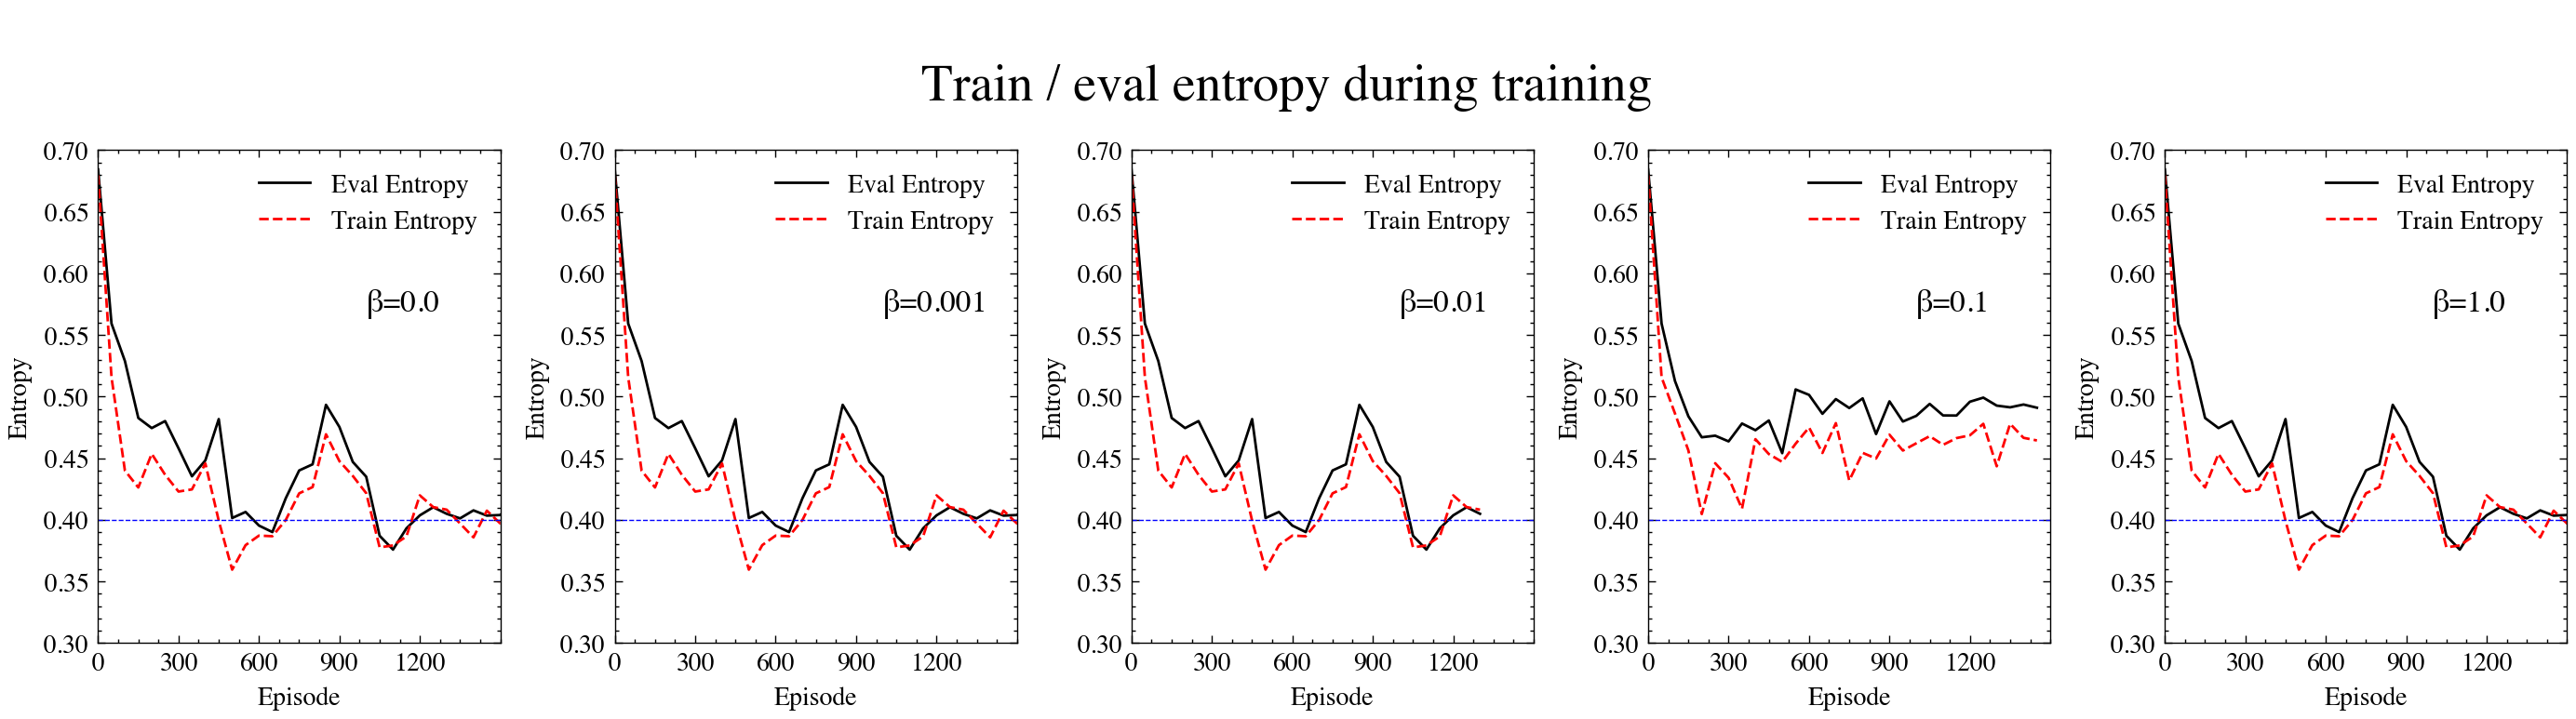

In [414]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,4))
fig.suptitle('\nTrain / eval entropy during training', fontsize = 20)
axs = axs.flatten()

entropy_coeffs = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
betas = ['0.0', '0.001', '0.01', '0.1', '1.0']

for entropy_coef, ax, beta in zip(entropy_coeffs, axs, betas):
    eval_entropy_steps, eval_entropy_values = eval_entropy['Step'], eval_entropy[entropy_coef]
    train_entropy_steps, train_entropy_values = train_entropy[train_entropy['Step'].isin(eval_entropy_steps)]['Step'], train_entropy[train_entropy['Step'].isin(eval_entropy_steps)][entropy_coef]

    ax.plot(eval_entropy_steps, eval_entropy_values, label='Eval Entropy')
    ax.plot(train_entropy_steps, train_entropy_values, label='Train Entropy')
    ax.axhline(y=0.4, color='blue', linestyle='--', linewidth=0.5)

    ax.set_xlabel('Episode', fontsize=10)
    ax.set_ylabel('Entropy', fontsize=10)

    ax.set_ylim([0.3, 0.7])
    ax.set_xlim([0.0, 1500])
    ax.set_xticks([i for i in range(0, 1500, 300)])
    ax.tick_params(axis='both', which='major', labelsize=8)

    ax.legend(prop={'size': 10})
    # ax.grid(True)
    ax.text(1000, 0.57, f'β={beta}', fontsize=12)

    ax.tick_params(axis='both', which='major', labelsize=10)



plt.tight_layout()
plt.show()

Заметим, что энтропия политики $\pi_{\theta}$ уменьшается с каждым эпизодом. Это означает, что агент обучается правильным образом, соблюдая exploration–exploitation баланс. Действия агента становятся более уверенными с течением времени. На графиках также видно, что разные коэффициенты $\beta$ энтропийной регуляризации влияют уверенность ответов модели на больших горизонтах.

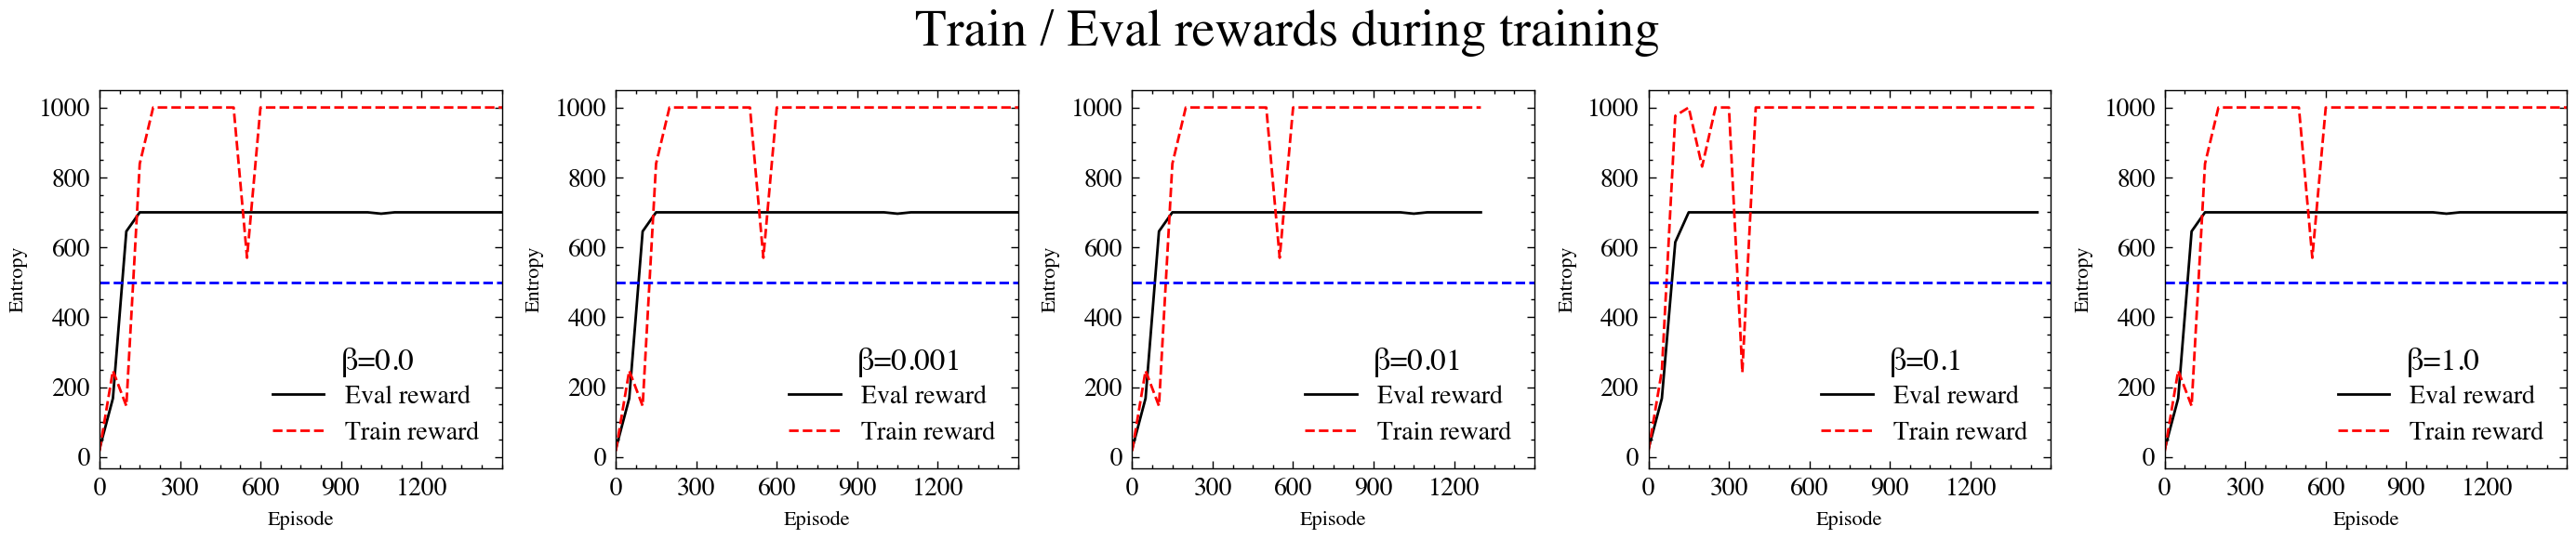

In [416]:
def draw_value_function_baseline_reward():

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,3))
    fig.suptitle('Train / Eval rewards during training', fontsize = 20)
    axs = axs.flatten()
    axs = axs.flatten()

    entropy_coeffs = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
    betas = ['0.0', '0.001', '0.01', '0.1', '1.0']

    for entropy_coef, ax, beta in zip(entropy_coeffs, axs, betas):
        eval_reward_steps, eval_reward_values = eval_reward['Step'], eval_reward[entropy_coef]
        train_reward_steps, train_reward_values = train_reward[train_reward['Step'].isin(eval_reward_steps)]['Step'], train_reward[train_reward['Step'].isin(eval_reward_steps)][entropy_coef]

        ax.plot(eval_reward_steps, eval_reward_values, label='Eval reward')
        ax.plot(train_reward_steps, train_reward_values, label='Train reward')
        ax.axhline(y=500, color='blue', linestyle='--', linewidth=1)

        ax.set_xlabel('Episode', fontsize=8)
        ax.set_ylabel('Entropy', fontsize=8)

        ax.set_xlim([0.0, 1500])
        ax.set_xticks([i for i in range(0, 1500, 300)])
        ax.tick_params(axis='both', which='major', labelsize=10)

        ax.legend(prop={'size': 10}, loc='lower right')
        # ax.grid(True)
        ax.text(900, 250, f'β={beta}', fontsize=12)



    plt.tight_layout()
    plt.show()
draw_value_function_baseline_reward()

Политики обученные $\text{REINFORCE}$ методом с value-function бейзлайном почти во всех случая сходятся к максимальному порогу награды примерно за $200$ эпизодов. При этом величина коэффициента энтропийной регуляризации $\beta$ в данных случаях слабо влияет на горизонт сходимости.

### RLOO Baseline

In [381]:
rloo_df_paths = [
    '../data/rloo/eval_avg_entropy.csv',
    '../data/rloo/eval_min_episode_reward.csv',
    '../data/rloo/eval_raward.csv',
    '../data/rloo/train_avg_entropy.csv',
    '../data/rloo/train_reward.csv',
]

rloo_dfs = list(map(lambda path: pd.read_csv(path), rloo_df_paths))

rloo_prefixes = [
    ('cart-pole-rloo-baseline-2025-03-11-22-51-17', 0),
    ('cart-pole-rloo-baseline-2025-03-11-21-44-33', 0.001),
    ('cart-pole-rloo-baseline-2025-03-11-19-43-34', 0.1),
    ('cart-pole-rloo-baseline-2025-03-11-18-36-30', 1),
    ('cart-pole-rloo-baseline-2025-03-11-20-34-19', 0.01),
]


# cart-pole-rloo-baseline-2025-03-11-22-51-17 beta 0 # lowest entropy
# cart-pole-rloo-baseline-2025-03-11-21-44-33 beta 0.001
# cart-pole-rloo-baseline-2025-03-11-19-43-34 beta 0.1
# cart-pole-rloo-baseline-2025-03-11-18-36-30 beta 1
# cart-pole-rloo-baseline-2025-03-11-20-34-19 beta 0.01

In [382]:
(eval_avg_entropy, eval_min_episode_reward, eval_raward, train_avg_entropy, train_reward) = map_dataframes(rloo_prefixes, rloo_dfs)

In [383]:
eval_avg_entropy

,Step,beta_0,beta_0_001,beta_0_01
0,0,0.692095,0.690664,0.669195
1,50,0.617017,0.589361,0.583757
2,100,0.490447,0.528663,0.545376
3,150,0.432124,0.466613,0.499747
4,200,0.416099,0.466197,0.453865
5,250,0.399426,0.520753,0.391557
6,300,0.437599,0.468821,0.398396
7,350,0.430247,0.417024,0.430581
8,400,0.278719,0.440605,0.429306
9,450,0.263798,0.459881,0.436887


<Axes: >

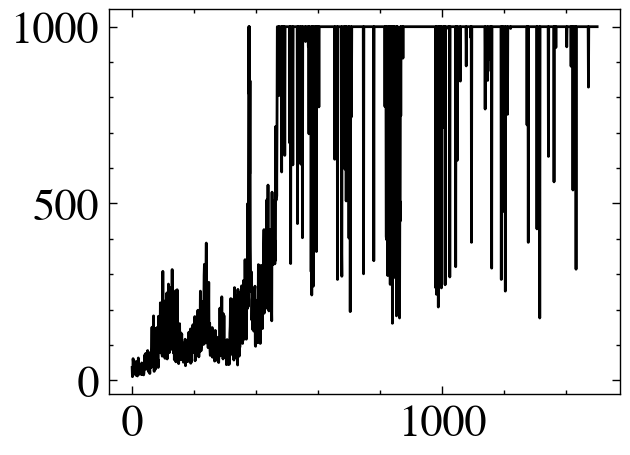

In [245]:
train_reward['beta_0'].plot()

### Average Reward Baseline

In [400]:
average_reward_df_paths = [
    '../data/average_reward/eval_entropy.csv',
    '../data/average_reward/eval_reward.csv',
    '../data/average_reward/eval_min_reward.csv',
    '../data/average_reward/train_entropy.csv',
    '../data/average_reward/train_reward.csv',
]

average_reward_dfs = list(map(lambda path: pd.read_csv(path), average_reward_df_paths))

average_rewards_prefixes = [
    ('cart-pole-average-reward-baseline-2025-03-10-10-16-06', 0),
    ('cart-pole-average-reward-baseline-2025-03-10-11-56-17', 0.001),
    ('cart-pole-average-reward-baseline-2025-03-10-13-05-59', 0.01),
    ('cart-pole-average-reward-baseline-2025-03-10-13-56-33', 0.1),
    ('cart-pole-average-reward-baseline-2025-03-10-15-36-09', 1.0),
]

(avrb_eval_entropy,
 avrb_eval_min_episode_reward,
 avrb_eval_reward,
 avrb_train_entropy,
 avrb_train_reward) = map_dataframes(average_rewards_prefixes, average_reward_dfs)

/var/folders/88/rz9pfrnd34q32tv5679ygvyh0000gn/T/ipykernel_96201/959950092.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


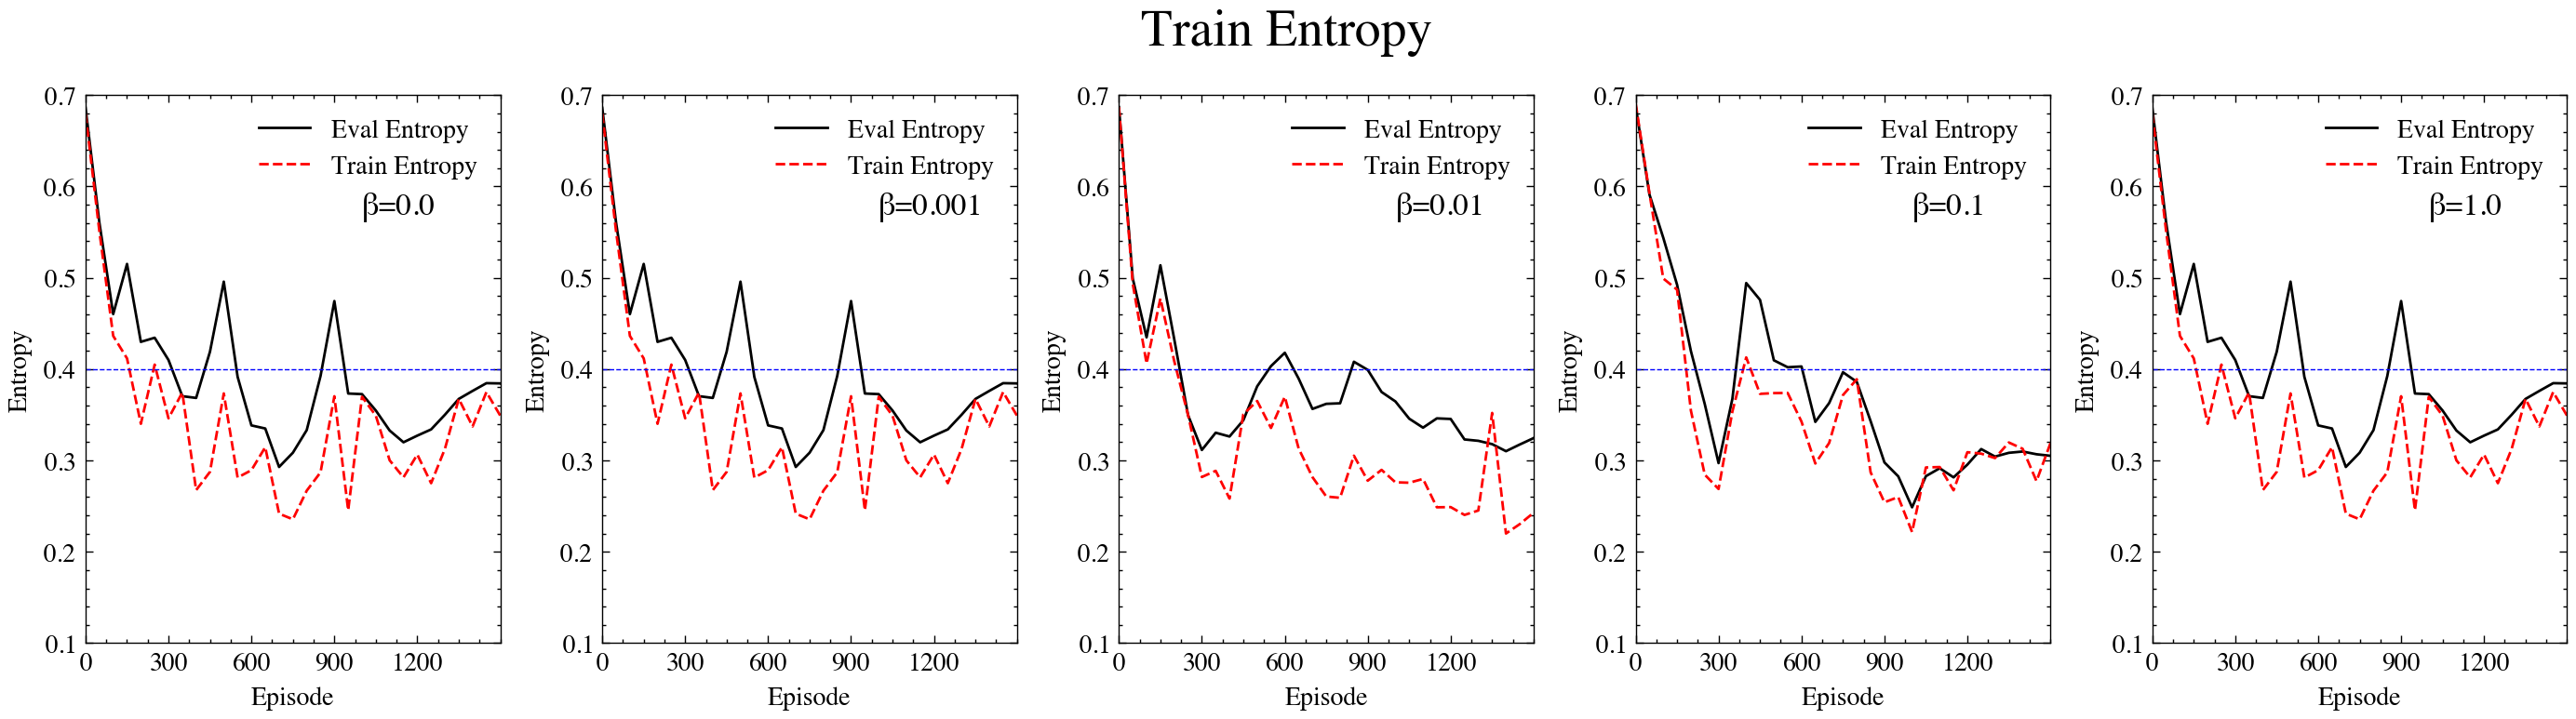

In [407]:
def draw_average_reward_entropy_plots(train_entropy: pd.DataFrame, eval_entropy: pd.DataFrame, title: str):

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(14,4))
    fig.suptitle(title, fontsize = 20)
    axs = axs.flatten()
    entropy_columns = ['beta_0', 'beta_0_001', 'beta_0_01', 'beta_0_1', 'beta_1_0']
    betas = ['0.0', '0.001', '0.01', '0.1', '1.0']
    for entropy_coef, ax, beta in zip(entropy_columns, axs, betas):
        eval_steps, eval_values = eval_entropy['Step'], eval_entropy[entropy_coef]

        selected_train_entropy = train_entropy[train_entropy['Step'].isin(eval_reward_steps)]
        train_steps, train_values = selected_train_entropy['Step'], selected_train_entropy[entropy_coef]

        ax.plot(eval_steps, eval_values, label='Eval Entropy')
        ax.plot(train_steps, train_values, label='Train Entropy')
        ax.axhline(y=0.4, color='blue', linestyle='--', linewidth=0.5)

        ax.set_xlabel('Episode', fontsize=10)
        ax.set_ylabel('Entropy', fontsize=10)

        ax.set_ylim([0.1, 0.7])
        ax.set_xlim([0.0, 1500])
        ax.set_xticks([i for i in range(0, 1500, 300)])
        ax.tick_params(axis='both', which='major', labelsize=8)

        ax.legend(prop={'size': 10})
        ax.text(1000, 0.57, f'β={beta}', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    fig.show()
draw_average_reward_entropy_plots(avrb_train_entropy, avrb_eval_entropy, 'Train Entropy')

### Behavioral Cloning

#### Сетап экспериментов

В качестве учителя была выбрана одна из моделей, среди обученных на предыдущем шаге. Для генерации пар state-action был выбран следующий подход. Взяты наборы $seeds_{eval}$, на основе них были запущены окружения и получены требуемые пары. Затем все пары были добавлены в общий датасет и перемешаны. Из датасетов было просемплировано $N \in [1000, 5000, 10000, 50000]$ пар.

Для клонирования поведения политики используется $CrossEntropyLoss$.

Одним из недостатков подхода $\text{Behavioral Cloning}$ является тот факт, что агент, попадающий в состояние, которого не было в обучающей выборке может начать вести себя непредсказуемо. Давайте возьмем политику $\pi_{teacher}$ и посмотрим на распределения параметров скорости/положения/угловой скорости/угла отклонения от вертикальной оси.

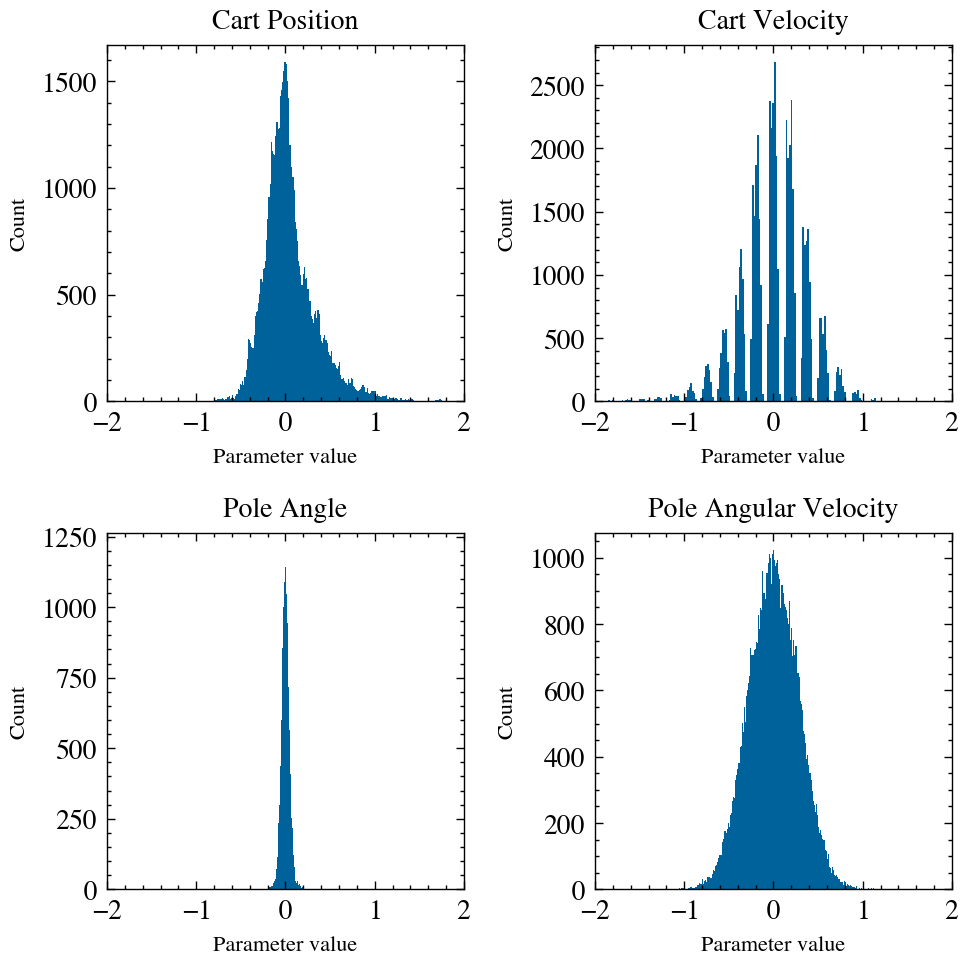

In [320]:
def draw_states():
    states = np.loadtxt('../data/states.txt')
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    fig.subplots_adjust(hspace=0.5)

    axs = axs.flatten()

    plot_properties = [
        ('Cart Position', [-2, 2]),
        ('Cart Velocity', (-2, 2)),
        ('Pole Angle', (-0.3, 0.3)),
        ('Pole Angular Velocity', (-2, 2)),
    ]

    for i, ax in enumerate(axs):
        ax.hist(states[:, i], bins=200, color='#00629B')
        ax.set_title(plot_properties[i][0], fontsize=10)
        ax.set_xlim(-2, 2)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_ylabel('Count', fontsize=8)
        ax.set_xlabel('Parameter value', fontsize=8)

    fig.tight_layout()
draw_states()

In [337]:
states = np.loadtxt('../data/states.txt')

In [345]:
states.shape

(57884, 4)